# TD1: Simplicial complexes and Homology

In this first practical session, we will use `gudhi` to create simplicial complexes and compute their homology groups and Betti numbers. We will first start with simple and synthetic examples, and then apply computational topology on a real-world data set of images.

First load the required Python libraries. You will need `numpy`, `gudhi`, `matplotlib`, `networkx` and `scikit-learn`.

In [1]:
import os
import itertools
import numpy as np
import gudhi as gd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.base    import BaseEstimator, TransformerMixin
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [2]:
%matplotlib notebook

## 1. Betti numbers of standard topological spaces

The goal of this first exercise is to get familiarized with `gudhi` and the `SimplexTree` data structure. Documentation is [here](https://gudhi.inria.fr/python/latest/simplex_tree_ref.html).

Q1. Triangulate the torus, represented as a quotient space.

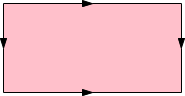

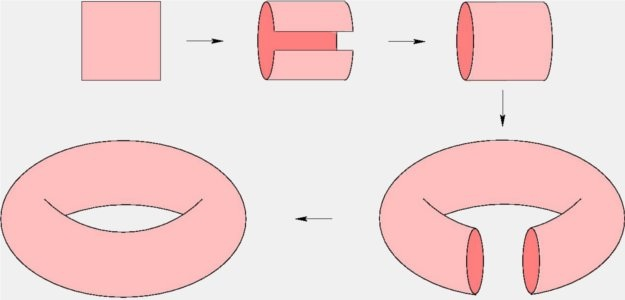

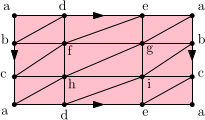

Q2. Enter your triangulation as a simplex tree in `gudhi`.

In [3]:
st = gd.SimplexTree()
st.insert([0,1,3])
st.insert([1,3,5])
st.insert([1,2,5])
st.insert([2,5,7])
st.insert([0,2,7])
st.insert([0,3,7])
st.insert([3,4,5])
st.insert([4,5,6])
st.insert([5,6,7])
st.insert([6,7,8])
st.insert([3,7,8])
st.insert([3,4,8])
st.insert([0,4,6])
st.insert([0,1,6])
st.insert([1,6,8])
st.insert([1,2,8])
st.insert([2,4,8])
st.insert([0,2,4])

True

Q3. Check that your triangulation is correct by computing the Betti numbers of your triangulation. You can use the `Betti_numbers` function below for this. If the Betti numbers are not correct, make sure that the number of simplices in your simplex tree matches the one of your triangulation (in each dimension).

In [4]:
def Betti_numbers(st):
    st.compute_persistence(persistence_dim_max=st.dimension()+1)
    return st.betti_numbers()

In [5]:
Betti_numbers(st)

[1, 2, 1]

In [6]:
dimension = 1

count = 0
for (splx,_) in st.get_simplices():
    if len(splx) == dimension + 1:
        count += 1
print(str(count) + ' simplices in dimension ' + str(dimension))

27 simplices in dimension 1


Q4. Do the same with the [dunce hat](https://en.wikipedia.org/wiki/Dunce_hat_(topology)). The dunce hat is a space known to be contractible (homotopy equivalent to a point), but not collapsible (you cannot deform the complex to a point by progressively removing its simplices).

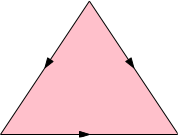

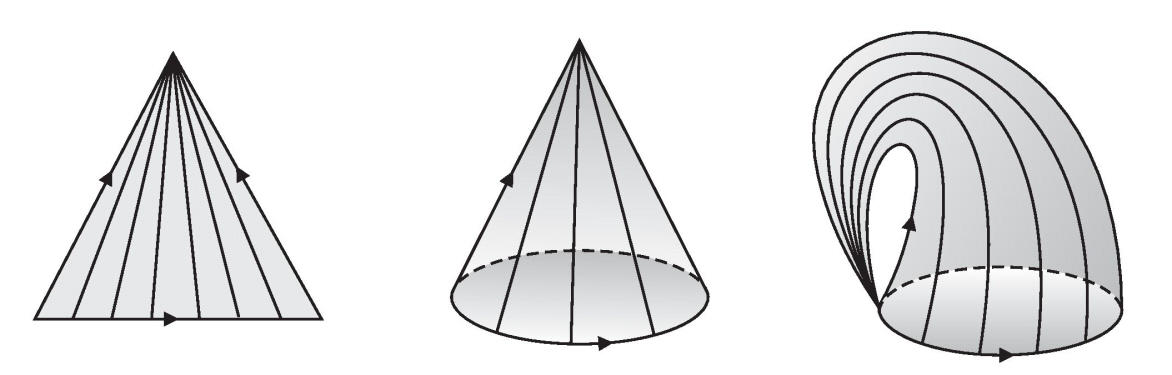

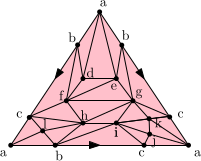

In [7]:
st = gd.SimplexTree()
st.insert([0,1,11])
st.insert([0,2,11])
st.insert([2,7,11])
st.insert([1,7,11])
st.insert([1,7,8])
st.insert([1,2,8])
st.insert([2,8,9])
st.insert([0,2,9])
st.insert([0,9,10])
st.insert([8,9,10])
st.insert([0,2,10])
st.insert([6,8,10])
st.insert([2,6,10])
st.insert([2,5,7])
st.insert([5,6,7])
st.insert([6,7,8])
st.insert([1,2,5])
st.insert([1,2,6])
st.insert([4,5,6])
st.insert([3,4,5])
st.insert([1,3,5])
st.insert([1,4,6])
st.insert([0,3,4])
st.insert([0,1,3])
st.insert([0,1,4])

True

In [8]:
Betti_numbers(st)

[1, 0, 0]

In [9]:
dimension = 1

count = 0
for (splx,_) in st.get_simplices():
    if len(splx) == dimension + 1:
        count += 1
print(str(count) + ' simplices in dimension ' + str(dimension))

36 simplices in dimension 1


## 2. Application to COIL data set

The goal of this second exercise is to visualize and classify a data set using simplicial complexes and Betti numbers. The data set is the Columbia Object Image Library, which is made of gray scale images of rotating objects.

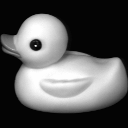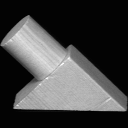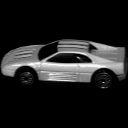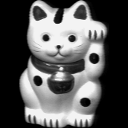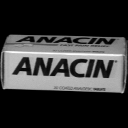

You can download the data [here](http://www-sop.inria.fr/abs/teaching/centrale-FGMDA/slides_mathieu/coil-20-proc.zip). Set up the `path` variable to where the data is in your machine.

In [10]:
path = './coil-20-proc/'

<IPython.core.display.Javascript object>


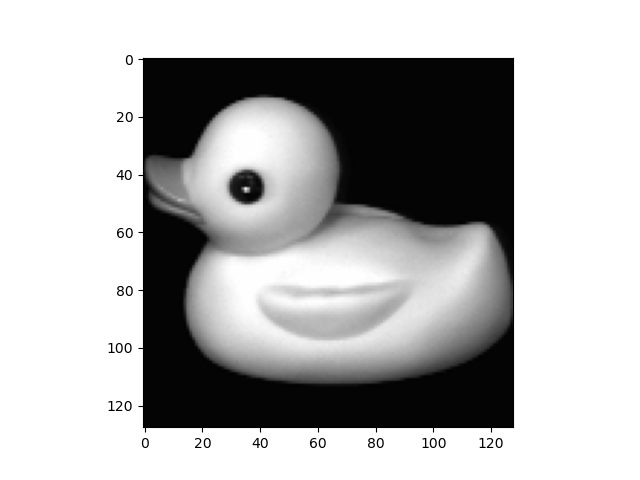

In [11]:
plt.figure()
plt.imshow(plt.imread(path + 'obj1__0.png'), cmap='gray')
plt.show()

We provide an implementation of the Mapper complex. Get familiarized with its arguments and their formats before using it.

Q1. Read the images and their labels (the object they represent) in `numpy` arrays.

In [12]:
images, labels = [], []
for img in os.listdir(path):
    images.append( np.array(plt.imread(path + img)).flatten() )
    labels.append(img.split('_')[0])
labels = np.array(labels)
images = np.vstack([img[None,:] for img in images])

Q2. Compute the Mapper complex (using the `MapperComplex` class in `gudhi`---documentation is [here](https://gudhi.inria.fr/python/latest/cover_complex_sklearn_isk_ref.html).) on the images of a given rotating object (using, e.g., PCA components as filters), and compute its Betti numbers. Try different filters, resolutions, gains and clusterings, and see how they influence the results.

In [13]:
indices = np.argwhere(labels == 'obj5').ravel()

In [14]:
pca = PCA(n_components=2).fit_transform(images[indices])

<IPython.core.display.Javascript object>


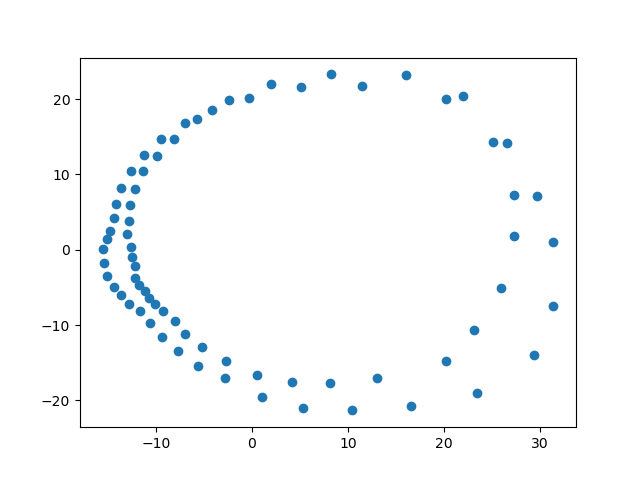

In [15]:
plt.figure()
plt.scatter(pca[:,0],pca[:,1])
plt.show()

In [30]:
from gudhi.cover_complex import MapperComplex
mapper = MapperComplex(input_type="point cloud",
                       filter_bnds=None,
                       resolutions=np.array([5]), gains=np.array([.3]), 
                       clustering=AgglomerativeClustering(n_clusters=None, linkage="single", 
                                                          distance_threshold=40, metric="euclidean"))
mapper = mapper.fit(images[indices], filters=pca[:,1:2], colors=pca[:,1:2],)

In [31]:
Betti_numbers(mapper.simplex_tree_)

[1, 1]

Q3. Use `networkx`, its `draw` function and the `get_networkx` method of the `MapperComplex` class to visualize the complex.

In [32]:
G = mapper.get_networkx()

<IPython.core.display.Javascript object>


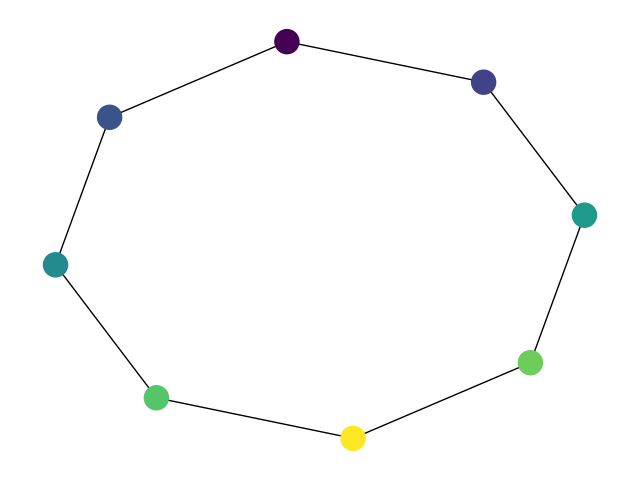

In [33]:
plt.figure()
nx.draw(G, pos=nx.kamada_kawai_layout(G), 
        node_color=[mapper.node_info_[v]["colors"][0] for v in G.nodes()],
       )
plt.show()

Q4. We are now going to classify images based on their Betti numbers. First, write a function that turns images into simplicial complexes, by triangulating every pixel with two triangles, and leaving aside pixels whose gray scale value is below a pre-defined threshold. Test your function on an image, compute the Betti numbers of its associated complex, and visualize the filtered image to check that the Betti numbers make sense.

In [34]:
def image_to_simplex_tree(image, threshold):
    num_rows, num_cols = image.shape[0], image.shape[1]
    st = gd.SimplexTree()
    for i in range(0,num_rows):
        for j in range(0,num_cols):
            if image[i,j] >= threshold:
                st.insert([num_rows*i+j,   num_rows*i+j+1,     num_rows*(i+1)+j])
                st.insert([num_rows*i+j+1, num_rows*(i+1)+j+1, num_rows*(i+1)+j])
    return st

In [35]:
I = plt.imread(path + 'obj1__0.png')

In [36]:
st = image_to_simplex_tree(I, 0.1)

In [37]:
Betti_numbers(st)

[1, 2, 0]

<IPython.core.display.Javascript object>


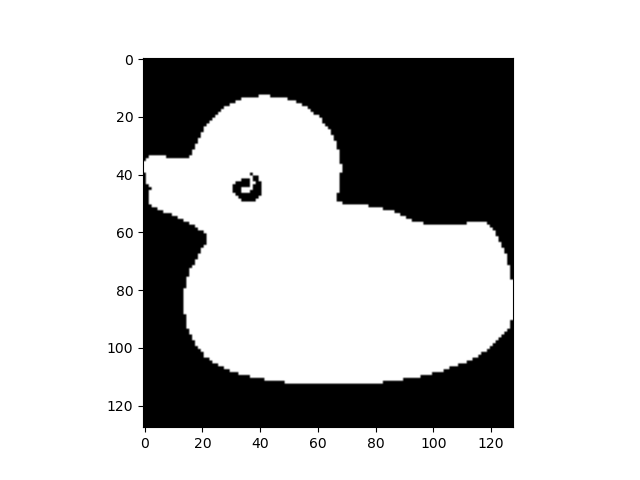

In [38]:
plt.figure()
plt.imshow(I>=0.1, cmap='gray')
plt.show()

Q5. Compute the Betti numbers of the complexes computed with a given threshold on the images associated to a few objects. Then, use these features to train classifiers (such as SVM or random forests) and compute their accuracies on random 80%/20% train/test splits of the data.

In [39]:
threshold = 0.1
topological_features = np.vstack([
    np.array(Betti_numbers(image_to_simplex_tree(
        np.reshape(I,[int(np.sqrt(len(I))),int(np.sqrt(len(I)))]), threshold)))[None,:2] for I in images
])

In [40]:
indices              = np.argwhere((labels == 'obj1')|(labels == 'obj2')|(labels == 'obj3')|(labels == 'obj4')).ravel()
test_size            = 0.2
perm                 = np.random.permutation(len(indices))
limit                = int(test_size * len(indices))
test_sub, train_sub  = perm[:limit], perm[limit:]
train_labs           = labels[indices[train_sub]]
test_labs            = labels[indices[test_sub]]

In [41]:
train_betti = topological_features[indices[train_sub]]
test_betti  = topological_features[indices[test_sub]]

In [42]:
rf = RandomForestClassifier().fit(train_betti, train_labs)
acc = rf.score(test_betti, test_labs)

In [43]:
print(acc)

0.8245614035087719


In [44]:
svm = SVC().fit(train_betti, train_labs)
acc = svm.score(test_betti, test_labs)

In [45]:
print(acc)

0.8596491228070176


Q6. Since Betti numbers are ordinal data, check the effect of one-hot encoding on the accuracies.

In [46]:
topological_features_ohe = OneHotEncoder().fit_transform(topological_features)
train_betti     = topological_features_ohe[indices[train_sub]]
test_betti      = topological_features_ohe[indices[test_sub]]

In [47]:
rf = RandomForestClassifier().fit(train_betti, train_labs)
acc = rf.score(test_betti, test_labs)

In [48]:
print(acc)

0.8245614035087719


In [49]:
svm = SVC().fit(train_betti, train_labs)
acc = svm.score(test_betti, test_labs)

In [50]:
print(acc)

0.8070175438596491
